In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sign-language-mnist' dataset.
Path to dataset files: /kaggle/input/sign-language-mnist


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
try:
    import kagglehub
except Exception as e:
    kagglehub = None
    print("Warning: kagglehub not available in this environment. If running locally, make sure kagglehub is installed.")

# Use kagglehub to download; if not available, user can manually place CSVs in ./data/
DATA_DIR = 'data_sign_mnist'
os.makedirs(DATA_DIR, exist_ok=True)

if kagglehub is not None:
    print("Downloading dataset with kagglehub...")
    path = kagglehub.dataset_download("datamunge/sign-language-mnist")
    print('Downloaded to:', path)
    # path may be a zip or a folder; try to extract
    if os.path.isfile(path) and path.endswith('.zip'):
        with zipfile.ZipFile(path, 'r') as z:
            z.extractall(DATA_DIR)
    elif os.path.isdir(path):
        # copy files into DATA_DIR if needed
        for fname in os.listdir(path):
            src = os.path.join(path, fname)
            dst = os.path.join(DATA_DIR, fname)
            if os.path.isfile(src) and not os.path.exists(dst):
                try:
                    from shutil import copyfile
                    copyfile(src, dst)
                except Exception:
                    pass
else:
    print(f"kagglehub not available — please put dataset CSVs into the folder: {DATA_DIR}")

Using Colab cache for faster access to the 'sign-language-mnist' dataset.
Downloaded to: /kaggle/input/sign-language-mnist


In [ ]:
possible_files = os.listdir(DATA_DIR)
print('Files found in data dir:', possible_files)

# helper to locate likely csvs
train_csv = None
test_csv = None
for f in possible_files:
    lf = f.lower()
    if 'train' in lf and lf.endswith('.csv'):
        train_csv = os.path.join(DATA_DIR, f)
    if 'test' in lf and lf.endswith('.csv'):
        test_csv = os.path.join(DATA_DIR, f)

Files found in data dir: ['sign_mnist_train.csv', 'sign_mnist_test.csv', 'amer_sign3.png', 'american_sign_language.PNG', 'amer_sign2.png']


In [ ]:
if train_csv is None and os.path.exists(os.path.join(DATA_DIR, 'sign_mnist_train.csv')):
    train_csv = os.path.join(DATA_DIR, 'sign_mnist_train.csv')
if test_csv is None and os.path.exists(os.path.join(DATA_DIR, 'sign_mnist_test.csv')):
    test_csv = os.path.join(DATA_DIR, 'sign_mnist_test.csv')

if train_csv is None:
    # try to find any csv and assume it's the full dataset
    csvs = [os.path.join(DATA_DIR, f) for f in possible_files if f.endswith('.csv')]
    if len(csvs) == 1:
        train_csv = csvs[0]
    elif len(csvs) >= 2:
        train_csv = csvs[0]
        test_csv = csvs[1]

if train_csv is None:
    raise FileNotFoundError(f"Could not find any dataset CSV in {DATA_DIR}. Please place sign_mnist CSV files there.")

print('train_csv =', train_csv)
print('test_csv =', test_csv)

train_csv = data_sign_mnist/sign_mnist_train.csv
test_csv = data_sign_mnist/sign_mnist_test.csv


In [ ]:
train_df = pd.read_csv(train_csv)
if test_csv is not None:
    test_df = pd.read_csv(test_csv)
else:
    test_df = None

print('Train shape:', train_df.shape)
if test_df is not None:
    print('Test shape:', test_df.shape)

Train shape: (27455, 785)
Test shape: (7172, 785)


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# Preprocessing

def df_to_images(df):
    labels = df['label'].values
    pixels = df.drop('label', axis=1).values.astype('float32')
    # Normalize to [0,1]
    pixels = pixels / 255.0
    # reshape to (n,28,28,1)
    pixels = pixels.reshape(-1, 28, 28, 1)
    return pixels, labels

X_train, y_train = df_to_images(train_df)
if test_df is not None:
    X_test, y_test = df_to_images(test_df)
else:
    # if no separate test, create one via train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

# Quick class distribution
unique, counts = np.unique(y_train, return_counts=True)
print('Classes in training set:', dict(zip(unique, counts)))

# Convert labels to categorical for training (sparse loss also supported; here we use sparse)
num_classes = len(np.unique(np.concatenate([y_train, y_test])))
print('Num classes:', num_classes)

# Remap labels to be 0-indexed and contiguous
unique_labels_present = np.unique(np.concatenate([y_train, y_test]))
label_mapping = {label: i for i, label in enumerate(unique_labels_present)}

y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

# Reconfirm num_classes (should be the same as before, but now labels are correctly mapped)
num_classes = len(np.unique(np.concatenate([y_train, y_test])))
print('Num classes (after remapping):', num_classes)

X_train shape: (27455, 28, 28, 1) y_train shape: (27455,)
X_test shape: (7172, 28, 28, 1) y_test shape: (7172,)
Classes in training set: {np.int64(0): np.int64(1126), np.int64(1): np.int64(1010), np.int64(2): np.int64(1144), np.int64(3): np.int64(1196), np.int64(4): np.int64(957), np.int64(5): np.int64(1204), np.int64(6): np.int64(1090), np.int64(7): np.int64(1013), np.int64(8): np.int64(1162), np.int64(10): np.int64(1114), np.int64(11): np.int64(1241), np.int64(12): np.int64(1055), np.int64(13): np.int64(1151), np.int64(14): np.int64(1196), np.int64(15): np.int64(1088), np.int64(16): np.int64(1279), np.int64(17): np.int64(1294), np.int64(18): np.int64(1199), np.int64(19): np.int64(1186), np.int64(20): np.int64(1161), np.int64(21): np.int64(1082), np.int64(22): np.int64(1225), np.int64(23): np.int64(1164), np.int64(24): np.int64(1118)}
Num classes: 24
Num classes (after remapping): 24


In [ ]:
# -----------------------------------------------------------------------------
# 5) Build the model (CNN)
# -----------------------------------------------------------------------------
# We'll follow a simple but effective architecture similar to many MNIST/CNN examples.

latent_dim = 64  # analogous concept to latent_dim used in your seq2seq project

def build_cnn_model(input_shape=(28,28,1), num_classes=25):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(latent_dim, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_cnn_model(input_shape=(28,28,1), num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,384 (403.84 KB)

 Trainable params: 102,936 (402.09 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 6) Callbacks
# -----------------------------------------------------------------------------
checkpoint_path = 'sign_mnist_best_weights.weights.h5'
early = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
ckpt = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

In [ ]:
# 7) Data augmentation (optional) & training
# -----------------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08
)

batch_size = 128
epochs = 10

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
steps_per_epoch = len(X_train) // batch_size

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early, ckpt, reduce_lr])

# Save weights and full model
model.save_weights('sign_mnist_weights.weights.h5')
model.save('sign_mnist_full_model.h5')

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 65s 302ms/step - accuracy: 0.9976 - loss: 0.0146 - val_accuracy: 0.9996 - val_loss: 0.0044 - learning_rate: 5.0000e-04
Epoch 2/10
  1/214 ━━━━━━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 1.0000 - loss: 0.0104

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9999 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 65s 306ms/step - accuracy: 0.9972 - loss: 0.0149 - val_accuracy: 0.9974 - val_loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.9976 - val_loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 79s 316ms/step - accuracy: 0.9980 - loss: 0.0117 - val_accuracy: 0.9940 - val_loss: 0.0145 - learning_rate: 5.0000e-04
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9923 - val_loss: 0.0201 - learning_rate: 5.0000e-04
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 67s 311ms/step - accuracy: 0.9986 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 4.5519e-04 - learning_rate: 2.5000e-04
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accu

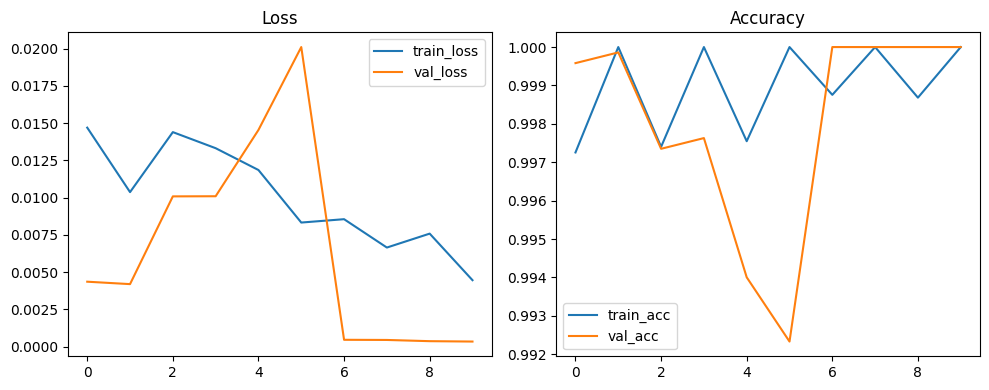

In [ ]:
# 8) Plots: loss & accuracy
# -----------------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f} — Test accuracy: {test_acc:.4f}")

225/225 - 3s - 15ms/step - accuracy: 1.0000 - loss: 3.3731e-04
Test loss: 0.0003 — Test accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


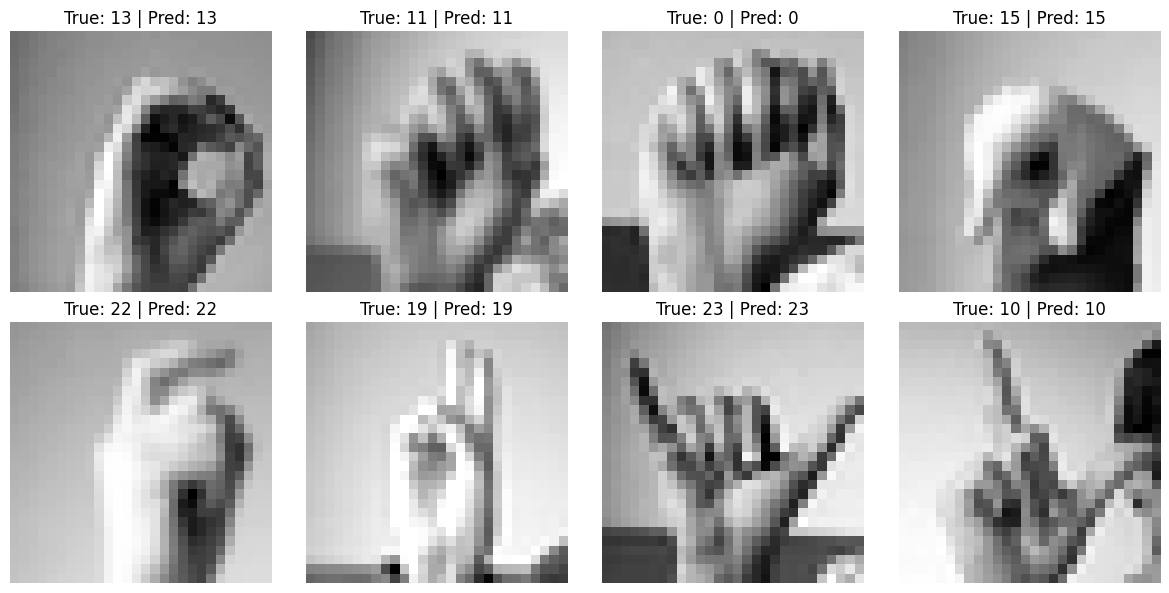

In [ ]:
# 10) Quick predictions on a few samples
# -----------------------------------------------------------------------------
import random
indices = random.sample(range(len(X_test)), 8)
preds = model.predict(X_test[indices])
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12,6))
for i, idx in enumerate(indices):
    plt.subplot(2,4,i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f'True: {y_test[idx]} | Pred: {pred_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 11) Save a small inference function
# -----------------------------------------------------------------------------

def predict_image(img_array, model=model):
    """Accepts one image array shape (28,28,1) scaled [0,1] and returns predicted label."""
    img = np.expand_dims(img_array, axis=0)
    probs = model.predict(img)
    return np.argmax(probs, axis=1)[0], np.max(probs)

# Example:
# label, conf = predict_image(X_test[0])
# print('Predicted:', label, 'confidence:', conf)

print('\nPipeline finished — model and weights saved in current directory.')



Pipeline finished — model and weights saved in current directory.
